In [1]:
import pandas as pd
from data import data_reader, TGDataset
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader
import numpy as np
from torchvision import models, transforms
import matplotlib.pyplot as plt

Tensor = torch.Tensor
rand_m = np.random.random
PATH = 'test1000/'

In [2]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
trm = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    normalize
])

def im_read(path):
    img = Image.open(path)
    return img.convert('RGB')

In [3]:
class args:
    bs = 128
    path = 'train2000/'
dr = data_reader(args, 'train2000/train2000.csv')

In [4]:
dr.mlb.classes_

array(['CITY', 'DESERT', 'FARMLAND', 'LAKE', 'MOUNTAIN', 'OCEAN'],
      dtype=object)

In [5]:
df = pd.read_csv('test1000.csv', header=None)

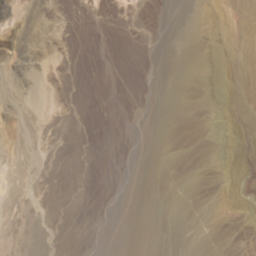

In [6]:
im = im_read(PATH + df[0][1])
im

In [7]:
class model_resnet(nn.Module):
    def __init__(self, num_class):
        super(model_resnet, self).__init__()
        self.resnet = models.resnet34()
        self.argp = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512, num_class)
    
    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)
        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)
        x = self.argp(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [8]:
model = model_resnet(6)
model.load_state_dict(torch.load('weights/resnet34_cos/best_params_acc98.25.pth'))
model.eval()

model_resnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_s

In [9]:
x = model(trm(im).unsqueeze(0))

In [10]:
x

tensor([[-6.9391, 10.7332, -4.5231, -2.8285, -1.3818, -0.4744]],
       grad_fn=<ThAddmmBackward>)

In [11]:
c = torch.max(x, 1)[1].item()

In [12]:
dr.mlb.classes_[c]

'DESERT'

In [13]:
sub = pd.DataFrame()

In [14]:
len(df)

1000

In [15]:
for i in range(len(df)):
    im = im_read(PATH + df[0][i])
    x = model(trm(im).unsqueeze(0))
    c = torch.max(x, 1)[1].item()
    sub = sub.append([(df[0][i], dr.mlb.classes_[c])])
    if i % 100 == 0: print(i)

0
100
200
300
400
500
600
700
800
900


In [16]:
len(sub)

1000

In [17]:
sub.to_csv('submission.csv', header=None, index=None, encoding='utf-8')